https://androidkt.com/tensorflow-keras-unet-for-image-image-segmentation/

https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

https://arxiv.org/pdf/1505.04597.pdf


In [1]:
import tensorflow as tf
import os
import sys
 
import numpy as np
 
from tqdm import tqdm
from itertools import chain
 
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3
 
IMAGE_DATA_PATH = 'training/images/'
MASK_DATA_PATH = 'training/groundtruth/'

SEED = 42
random.seed = SEED
np.random.seed = SEED

In [3]:
# Set image patch size in pixels
# IMG_PATCH_SIZE should be a multiple of 4
# image size should be an integer multiple of this number!
IMG_PATCH_SIZE = 16

In [4]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [5]:
def imgs_to_patches(imgs):
    num_images = len(imgs)
    
    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = [img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]
    return np.asarray(data)

In [6]:
images_filenames = os.listdir(IMAGE_DATA_PATH)

In [7]:
X = np.zeros((len(images_filenames), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(images_filenames), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
 
for n, filename in tqdm(enumerate(images_filenames), total=len(images_filenames)):   
    img = imread(IMAGE_DATA_PATH + filename)[:,:,:IMG_CHANNELS]
    X[n] = img
    mask = imread(MASK_DATA_PATH + filename)
    mask = np.expand_dims(mask, axis=-1)
    Y[n] = mask
 
x_train=imgs_to_patches(X) 
y_train=imgs_to_patches(Y)

100%|██████████| 100/100 [00:01<00:00, 75.22it/s]


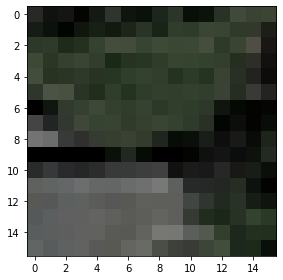

In [8]:
imshow(x_train[1])

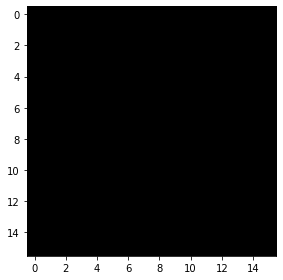

In [9]:
imshow(np.squeeze(y_train[1]))

In [10]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_PATCH_SIZE, IMG_PATCH_SIZE, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 16)   448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 16, 16)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
checkpoint_path = "checkpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=20,
                    callbacks=callbacks)
 

Train on 56250 samples, validate on 6250 samples
Epoch 1/20
56224/56250 [============================>.] - ETA: 0s - loss: 0.4652 - accuracy: 0.7878
Epoch 00001: saving model to checkpoint/cp.ckpt
56250/56250 [==============================] - 141s 3ms/sample - loss: 0.4652 - accuracy: 0.7877 - val_loss: 0.3785 - val_accuracy: 0.8326
Epoch 2/20
56240/56250 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8161
Epoch 00002: saving model to checkpoint/cp.ckpt
56250/56250 [==============================] - 138s 2ms/sample - loss: 0.3935 - accuracy: 0.8160 - val_loss: 0.3485 - val_accuracy: 0.8550
Epoch 3/20
56240/56250 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8282
Epoch 00003: saving model to checkpoint/cp.ckpt
56250/56250 [==============================] - 141s 2ms/sample - loss: 0.3706 - accuracy: 0.8282 - val_loss: 0.3331 - val_accuracy: 0.8605
Epoch 4/20
56224/56250 [============================>.] - ETA: 0s - loss: 0.3545 - accurac

1/1 [==============================] - 0s 210ms/sample


/home/bastien/Anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


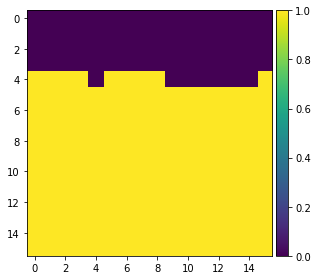

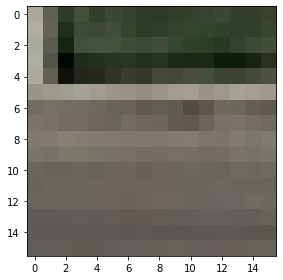

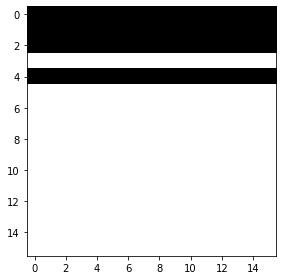

In [12]:

idx = 12#random.randint(0, len(x_train))
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()
imshow(np.squeeze(y_train[idx]))

In [13]:
# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, w, h, labels):
    array_labels = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if labels[idx][0] > 0.5:  # bgrd
                l = 0
            else:
                l = 1
            array_labels[j:j+w, i:i+h] = l
            idx = idx + 1
    return array_labels

In [14]:
def prediction_patches_to_img(patches):
    patch_side = patches[0].shape[0]
    img_side = np.sqrt(patch_side*patch_side*len(patches)).astype(np.int64)
    print(img_side)
    img = np.zeros([img_side, img_side])
    l = 0
    c = 0
    for patch in patches:
        for i in range(0, patch_side):
            for j in range(0, patch_side):
                img[i+c][j+l] = patch[i][j]
        c+= patch_side
        if c == img_side:
            c = 0
            l += patch_side
        
    return img     

In [15]:
def get_prediction(img):
    patches=img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE)
    predictions = []
    for patch in patches:
        patch=np.expand_dims(patch, axis=0)
        predict = model.predict(patch, verbose=0)
        
        predict = (predict > 0.5).astype(np.uint8)
        predictions.append(np.squeeze(predict[0]))

    return prediction_patches_to_img(predictions)

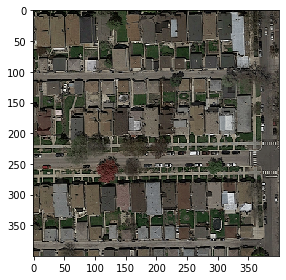

In [16]:
imshow(X[12])

400


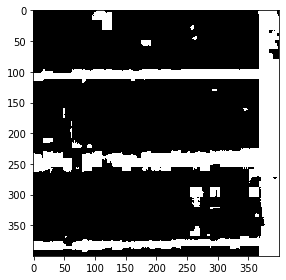

In [17]:
imshow(get_prediction(X[12]))

In [18]:
PIXEL_DEPTH=255
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

In [ ]:
print("Running prediction on submission set")
submission_data_dir = 'test_set_images/'
prediction_submission_dir = "predictions_submission/"
if not os.path.isdir(prediction_submission_dir):
    os.mkdir(prediction_submission_dir)
for i in range(1, 15):
    pimg = imread(submission_data_dir + f"test_{i}/test_{i}.png")[:,:,:IMG_CHANNELS]
        
    pimg = get_prediction(pimg)
    n_channels = len(pimg.shape)
    w = pimg.shape[0]
    h = pimg.shape[1]
    if n_channels == 3:
        cimg = pimg
    else:
        cimg = np.zeros((w, h, 3), dtype=np.uint8)
        pimg8 = img_float_to_uint8(pimg)
        cimg[:, :, 0] = pimg8
        cimg[:, :, 1] = pimg8
        cimg[:, :, 2] = pimg8
    
    Image.fromarray(cimg).save(prediction_submission_dir + f"gt_{i}.png")

Running prediction on submission set
608
608
608
608
608
608
608
608
608
608
608
608
608
608
608
608
608
608
